# Using EcoFOCIpy to process raw field data

## Mooring / Timeseries Data

Basic workflow for each instrument grouping is *(initial archive level)*:
- Parse data from raw files into pandas dataframe
- output initial files (pandas->csv) **ERDDAP NRT** when no meta data is added

Convert to xarray dataframe for all following work *(working or final data level):
- ingest metadata from deployment/recovery records or cast logs
- process data beyond simple file translate
- apply any calibrations or corrections
    + field corrections
    + offsets
    + instrument compensations
    + some QC were available... this would be old-school simple bounds mostly
- adjust time bounds and sample frequency (xarray dataframe)
- save as CF netcdf via xarray: so many of the steps above are optional
    + **ERDDAP NRT or preliminary** if no corrections, offsets or time bounds are applied but none/some meta data is, this is an internally hosted dataset for primary analysis, quick review, and historical purposes.
    + **Working and awaiting QC** has no ERDDAP representation and is a holding spot, often has deck data removed.  It is usually a combination of editable csv files and archivable netcdf files
    + **ERDDAP Final** fully calibrated, qc'd and populated with meta information.  Used for distribution and science analysis

Plot for preview and QC
- preview images (indiv and/or collectively)
- manual qc process
- automated qc process ML/AI

## Example below is for SBE-16 but the workflow is similar for all instruments.

Future processing of this instrument can be a simplified (no markdown) process which can be archived so that the procedure can be traced or updated

In [34]:
%matplotlib inline
import matplotlib.pyplot as plt
import yaml

import ecofocipy.io.sbe_parser as sbe_parser #<- instrument specific
import ecofocipy.io.ncCFsave as ncCFsave
import ecofocipy.metaconfig.load_config as load_config

The sample_data_dir should be included in the github package but may not be included in the pip install of the package

## Simple Processing - first step

In [35]:
sample_data_dir = '/Users/bell/Programs/EcoFOCIpy/'
user_data_dir = '/Users/bell/ecoraid/2019/Moorings/19ckp5a/'

In [36]:
###############################################################
# edit to point to {instrument sepcific} raw datafile 
datafile = user_data_dir+'rawconverted/sbe16/19ckp5a_sbe16_4426_48.cnv'
instrument = 'SBE-16 4426'
mooring_meta_file = user_data_dir+'logs/19CKP-5A.yaml'
inst_meta_file = sample_data_dir+'staticdata/instr_metaconfig/sbe16_cf.yaml'
institution_meta_file = sample_data_dir+'staticdata/institutional_meta_example.yaml' #include uaf?
inst_shortname = 's16'
###############################################################

#init and load data
sbe16_wop = sbe_parser.sbe16()
(sbe16_wop_data,sbe16_wop_header) = sbe16_wop.parse(filename=datafile,
                                                    return_header=True,
                                                    datetime_index=True) 

In [37]:
sbe16_wop_header

['* Sea-Bird SBE16plus Data File:\n',
 '* FileName = C:\\Users\\foci\\Documents\\2022\\sikuliaq_downloads\\19ckp5a_sbe16_4426_48.5m.hex\n',
 '* Software Version 1.59\n',
 '* Temperature SN =  4426\n',
 '* Conductivity SN =  4426\n',
 '* System UpLoad Time = Feb 04 2022 18:34:34\n',
 '** realtime: 183240\n',
 '** instime: 180510\n',
 '* ds\n',
 '* SBE 16plus V 1.7  SERIAL NO. 4426    04 Feb 2022  18:05:58\n',
 '* vbatt = 11.5, vlith =  8.4, ioper =  50.8 ma, ipump =   0.4 ma,\n',
 '* iext23 =   0.4 ma\n',
 '*\n',
 '* status = not logging\n',
 '* sample interval = 3600 seconds, number of measurements per sample = 4\n',
 '* samples = 21978, free = 677072\n',
 '* run pump during sample, delay before sampling = 2.0 seconds\n',
 '* transmit real-time = no\n',
 '* battery cutoff =  7.5 volts\n',
 '* pressure sensor = none\n',
 '* SBE 38 = no, SBE 50 = no, Gas Tension Device = no\n',
 '* Ext Volt 0 = no, Ext Volt 1 = no, Ext Volt 2 = no, Ext Volt 3 = yes\n',
 '* echo commands = yes\n',
 '* out

In [38]:
#provide original variable names from SBE file
sbe_parser.seabird_header(filename=datafile)[2]

{0: 'timeS',
 1: 'timeSCP',
 2: 'c0S/m',
 3: 'sal00',
 4: 'tv290C',
 5: 'par',
 6: 'flag'}

In [39]:
sbe16_wop_data

,timeS,timeSCP,c0S/m,sal00,tv290C,par,flag
date_time,,,,,,,
2019-08-04 01:00:03,0.0,216.041701,0.000008,0.0086,16.6732,1.332400,0.0
2019-08-04 02:00:03,3600.0,216.083368,0.000032,0.0084,16.4350,0.260440,0.0
2019-08-04 03:00:03,7200.0,216.125035,0.000068,0.0083,16.2306,0.912880,0.0
2019-08-04 04:00:03,10800.0,216.166701,0.000165,0.0083,15.7421,0.276100,0.0
2019-08-04 05:00:03,14400.0,216.208368,0.000168,0.0086,16.4235,0.288980,0.0
...,...,...,...,...,...,...,...
2022-02-04 14:00:03,79102800.0,1131.583370,-0.000037,0.0000,16.9654,0.055129,0.0
2022-02-04 15:00:03,79106400.0,1131.625030,-0.000025,0.0000,16.9790,0.055344,0.0
2022-02-04 16:00:03,79110000.0,1131.666700,-0.000037,0.0000,16.9938,0.054639,0.0


## Time properties

Its unusual that our clocks drift to the point of concern for our instruments (if an instrument is off by 3 minutes but only sampling hourly... regridding that data will result in minimal changes).  However, there are a few time oriented modifications that may need to be made.

The can be classified into two categories:
+ interpolate: these change the parameter values in accordance with the time edits
    - linear interpolation is most common
    - averaging of data and rebinning/resampling is also common (this needs to have the "time lable" thought out...)
    - decimating is less common but does not impact the max/min values
+ shift: these do not alter the measurements, just the timestamps they are associated with
    - the round function will work well to correct small time errors/drifts **common**
    - dropping extra precision on time (if you want hourly measurements, just remove all minute/second info... could cause large errors if rounding would have been more appropriate)

It is very easy to use pandas interplation and resample methods on the dataframe as is.  A few steps are suggested below:
- parse out on-deck (predeployment and recovery) data.  This can be done via pandas or xarray but requires the mooring metadata to have been read in.  See future steps below.
- even if the sample frequency is set to the desired measurement frequency, it would be good to perform a quick regridding as an assurance task
- FOCI data is usualy 1min, 10min, 1hr - and the 1min data is a fairly new (sbe56) data stream
    + subsampling high frequency data to lower frequency is easy via df.resample().mean() but it will label the new datapoint per default instructions.  The default is to label it with the left boundary of the bin.
    + you may want to take the median instead of the mean for noisy data (fluorometer) , occasionally decimating may be more appropriate if you want to downsize the dataset size but not smear features
    + shifting times can be a bit more involved.  There are two primary ways to do it, interpolate or shift (round)
        - to interpolate, you will need to upsample your data to a higher frequency which will generate missing values, then interpolate (with a maximum gap size), then decimate.  This always has the artifact of smoothing data and decreasing the min/max values. **common on microcats and other 10min datasets**
        - shifting usually just involves droping extra time "digits", if you want hourly, you could just drop the trailing minutes assuming you are just off the hour (8:05 -> 8:00) or you can round to the nearest time unit but niether of these changes the data value, just the time associated with it. **common on seacats and other hourly datasets**
        - you may also be able to *shift* using the pandas datetime round function and specifing the desired frequency.
    + I suggest if no change is needed... df.index.round(freq=*'your native sample freq'*)
    

1hr data sample period.  Maintain this and just round to the nearest hour (its only off by seconds ~10)  
**Don't account for drift (the instrument was ~30min behind the gps at recovery)** A linear correction and resampling comparison should be performed.  A choice of rounding vs interpolating would need to be determined to regrid data back on the hour.

In [40]:
sbe16_wop_data.index = sbe16_wop_data.index.round(freq='1H')
sbe16_wop_data

,timeS,timeSCP,c0S/m,sal00,tv290C,par,flag
date_time,,,,,,,
2019-08-04 01:00:00,0.0,216.041701,0.000008,0.0086,16.6732,1.332400,0.0
2019-08-04 02:00:00,3600.0,216.083368,0.000032,0.0084,16.4350,0.260440,0.0
2019-08-04 03:00:00,7200.0,216.125035,0.000068,0.0083,16.2306,0.912880,0.0
2019-08-04 04:00:00,10800.0,216.166701,0.000165,0.0083,15.7421,0.276100,0.0
2019-08-04 05:00:00,14400.0,216.208368,0.000168,0.0086,16.4235,0.288980,0.0
...,...,...,...,...,...,...,...
2022-02-04 14:00:00,79102800.0,1131.583370,-0.000037,0.0000,16.9654,0.055129,0.0
2022-02-04 15:00:00,79106400.0,1131.625030,-0.000025,0.0000,16.9790,0.055344,0.0
2022-02-04 16:00:00,79110000.0,1131.666700,-0.000037,0.0000,16.9938,0.054639,0.0


<AxesSubplot:xlabel='date_time'>

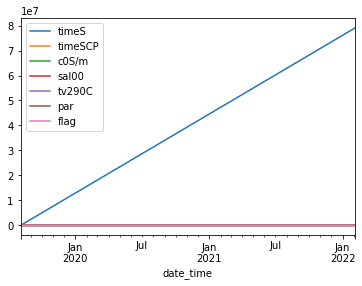

In [41]:
sbe16_wop_data.plot()

## Add Deployment meta information

Two methods are available (if comming from python2 world - ordereddict was important... in py38 a dictionary is inherently ordered)

In [42]:
#just a dictionary of dictionaries - simple
with open(mooring_meta_file) as file:
    mooring_config = yaml.full_load(file)

In [43]:
mooring_config['Instrumentation'][instrument]

{'InstType': 'SBE-16',
 'SerialNo': '4426',
 'DesignedDepth': 48.5,
 'ActualDepth': 43.5,
 'PreDeploymentNotes': 'Start on 8/4 00:00:00',
 'PostDeploymentNotes': '',
 'Deployed': 'y',
 'Recovered': 'y'}

## Add Instrument meta information

Time, depth, lat, lon should be added regardless (always our coordinates) but for a mooring site its going to be a (1,1,1,t) dataset
The variables of interest should be read from the data file and matched to a key for naming.  That key is in the inst_config file seen below and should represent common conversion names in the raw data

In [44]:
#just a dictionary of dictionaries - simple
with open(institution_meta_file) as file:
    institution_config = yaml.full_load(file)

In [45]:
with open(inst_meta_file) as file:
    inst_config = yaml.full_load(file)


In [46]:
#sbe16 data uses header info to name variables... but we want standard names from the dictionary I've created, so we need to rename column variables appropriately
#rename values to appropriate names, if a value isn't in the .yaml file, you can add it
sbe16_wop_data = sbe16_wop_data.rename(columns={'tv290C':'temperature',
                        'sal00':'salinity',
                        'sbeox0Mm/Kg':'oxy_conc',
                        'sbeox0ML/L':'oxy_concM',
                        'sigma-È00':'sigma_theta',
                        'sigma-t00':'sigma_t',
                        'CStarAt0':'Attenuation',
                        'CStarTr0':'Transmittance',
                        'flECO-AFL':'chlor_fluorescence',
                        'empty':'empty', #this will be ignored
                        'flag':'flag'})
sbe16_wop_data.sample()

,timeS,timeSCP,c0S/m,salinity,temperature,par,flag
date_time,,,,,,,
2021-05-18 13:00:00,56462400.0,869.541701,2.649444,33.5597,-1.7726,0.05361,0.0


In [47]:
# Add meta data and prelim processing based on meta data
# Convert to xarray and add meta information - save as CF netcdf file
# pass -> data, instmeta, depmeta
sbe16_wop_nc = ncCFsave.EcoFOCI_CFnc(df=sbe16_wop_data, 
                                instrument_yaml=inst_config, 
                                operation_yaml=mooring_config,
                                operation_type='mooring', 
                                instrument_id=instrument, 
                                inst_shortname=inst_shortname)
sbe16_wop_nc

At this point, you could save your file with the `.xarray2netcdf_save()` method and have a functioning dataset.... but it would be very simple with no additional qc, meta-data, or tuned parameters for optimizing software like ferret or erddap.

In [48]:
# expand the dimensions and coordinate variables
# renames them appropriatley and prepares them for meta-filled values
sbe16_wop_nc.expand_dimensions()

In [49]:
#build list from columsn in data - if a variable isn't in the yaml file, it will be dropped from the final data fields
sbe16_wop_nc.variable_meta_data(variable_keys=list(sbe16_wop_data.columns.values),drop_missing=True)
sbe16_wop_nc.temporal_geospatioal_meta_data(depth='actual')
#adding dimension meta needs to come after updating the dimension values... BUG?
sbe16_wop_nc.dimension_meta_data(variable_keys=['depth','latitude','longitude'])

The following steps can happen in just about any order and are all meta-data driven.  Therefore, they are not required to have a functioning dataset, but they are required to have a well described dataset

In [50]:
#add global attributes
sbe16_wop_nc.deployment_meta_add()
sbe16_wop_nc.get_xdf()

#add instituitonal global attributes
sbe16_wop_nc.institution_meta_add(institution_yaml=institution_config)

#add instrument global attributes
sbe16_wop_nc.instrument_meta_data()

#add creation date/time - provenance data
sbe16_wop_nc.provinance_meta_add()

#provide intial qc status field
sbe16_wop_nc.qc_status(qc_status='unknown')


## Save CF Netcdf files

Currently stick to netcdf3 classic... but migrating to netcdf4 (default) may be no problems for most modern purposes.  Its easy enough to pass the `format` kwargs through to the netcdf api of xarray.

In [51]:
# combine trim (not mandatory) and filename together (saves to test.nc without name)

depth = str(int(mooring_config['Instrumentation'][instrument]['ActualDepth'])).zfill(4)
# mooring_yaml['Instrumentation'][self.instrument_id]['DesignedDepth'])).zfill(4) #<-- alternative
filename = "".join(mooring_config['MooringID'].split('-')).lower()+'_'+inst_shortname+'_'+depth+'m.nc'
sbe16_wop_nc.xarray2netcdf_save(xdf = sbe16_wop_nc.autotrim_time(),
                           filename=filename,format="NETCDF3_CLASSIC")

# don't trim the data and pass your own filename
# sbe16_wop_nc.xarray2netcdf_save(xdf = sbe16_wop_nc.get_xdf(),
#    filename=filename,format="NETCDF4_CLASSIC")

In [52]:
sbe16_wop_nc.get_xdf()

<xarray.Dataset>
Dimensions:      (time: 21978, depth: 1, latitude: 1, longitude: 1)
Coordinates:
  * time         (time) datetime64[ns] 2019-08-04T01:00:00 ... 2022-02-04T18:...
  * latitude     (latitude) float64 71.2
  * longitude    (longitude) float64 -158.0
  * depth        (depth) float64 43.5
Data variables:
    salinity     (time, depth, latitude, longitude) float64 0.0086 ... 0.0
    temperature  (time, depth, latitude, longitude) float64 16.67 16.43 ... 17.3
    par          (time, depth, latitude, longitude) float64 1.332 ... 0.05715
Attributes: (12/33)
    Latitude_DegMMddW:                      71 12.22 N
    Longitude_DegMMddN:                     158 00.722 W
    MooringID:                              19CKP-5A
    platform_deployment_date:               2019-08-20T04:55:00Z
    platform_deployment_cruise_name:        OS1901
    platform_recovery_date:                 2021-10-31T22:25:00Z
    ...                                     ...
    InstrumentSerialNumber:                 4426
    InstrumentType:                         SBE-16
    date_created:                           2022-02-16T10:38:22Z
    date_modified:                          
    QC_indicator:                           unknown
    history:                                Trimmed to deployment.

In [53]:
try:
    print(sbe16_wop_nc.autotrim_time().pressure.mean())
except:
    print(f'likely no pressure variable in datafile')

likely no pressure variable in datafile


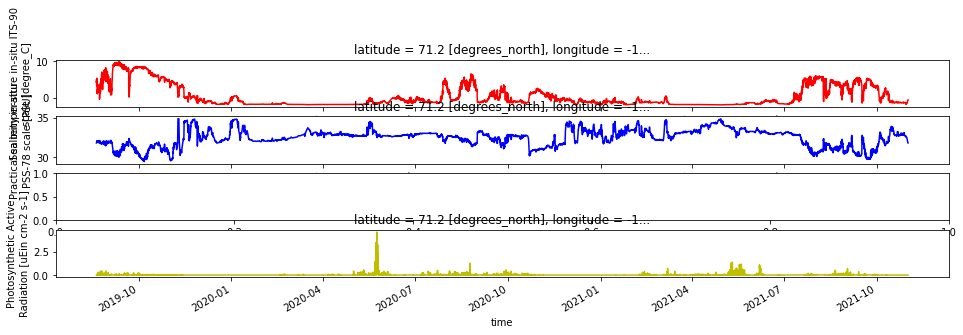

In [64]:
fig, ax = plt.subplots(4,figsize=(16, 4))
sbe16_wop_nc.autotrim_time().temperature.plot(ax=ax[0],color='r')
sbe16_wop_nc.autotrim_time().salinity.plot(ax=ax[1],color='b')
try:
    sbe16_wop_nc.autotrim_time().pressure.plot(ax=ax[2],color='k')
except:
    pass
sbe16_wop_nc.autotrim_time().par.plot(ax=ax[3],color='y')


In [55]:
#csvoutput if necessary - untrimmed for deck analysis
(sbe16_wop_nc.get_xdf().to_dataframe()).to_csv(filename.replace('nc','csv'))
#csvoutput of trimmed data for manual edit
(sbe16_wop_nc.autotrim_time().to_dataframe()).to_csv(filename.replace('nc','trimmed.csv'))

## Next Steps

QC of data (plot parameters with other instruments)
- be sure to updated the qc_status and the history

- **TODO** Programmatically simplify following tools

In [56]:
import pandas as pd
import xarray as xr
import datetime
import ecofocipy.io.erddap as erddap

url = "http://akutan.pmel.noaa.gov:8080/erddap"

erddap.test_erddap_connection(url=url) #basic test for connection to internal server, no response is a good thing

In [62]:
#grap deploy/recover cast data from erddap hosted sets - you have to know which profile you want though
depcast = erddap.erddapCTDretrieve(url=url,cruiseid='os1901l1',qclevel='final',concastno='036')
# reccast = erddap.erddapCTDretrieve(url=url,cruiseid='os1901l1',qclevel='final',concastno='036')

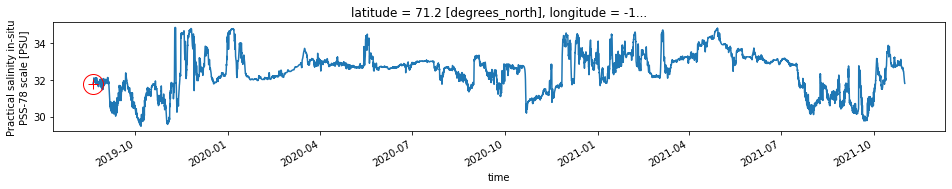

In [63]:
#plot ctd values with a small circular radius and zoom in on near their equivalent mooring time span, we are looking for visual discrepencies
#cycle through each depth and plot respective plot
depth = int(mooring_config['Instrumentation'][instrument]['ActualDepth'])

fig, ax = plt.subplots(1,figsize=(16, 2))
sbe16_wop_nc.autotrim_time().salinity.plot(x="time",hue="depth",ax=ax, add_legend=False);
ax.plot(pd.to_datetime(depcast[depcast['pressure (dbar)'] == depth]['time (UTC)']),
        depcast[depcast['pressure (dbar)'] == depth]['S_41 (PSU)'],
        'o',markersize=20,markerfacecolor='none',markeredgecolor='red')
ax.plot(pd.to_datetime(depcast[depcast['pressure (dbar)'] == depth]['time (UTC)']),
        depcast[depcast['pressure (dbar)'] == depth]['S_41 (PSU)'],
        '+',markersize=10,markerfacecolor='none',markeredgecolor='red')


### QC Notes from plots

- **no pressure var - so assume pressure correction from other depths**
- Salinity Spikes mid campaign and near the end should be removed
- rough field check points look good at the large scale


### Post Manual QC load data and rebuild nc file

- using excel for a few points or a dynamic web map for multiple (a tool on ecofoci-field.pmel.noaa.gov) or any other method to identify spikes
**NOTE** if you use excel, be cautious about how your time is formatted (its important) - use custom formatting and make it of the form `yyyy-mm-ddTHH:MM:SSZ` to assure proper read in to xarray

*TODO:* use erddap hosted data 

In [59]:
# this task only needs to be run once and only if you are archiving deck data in the initial archive csv
# (sbe16_wop_nc.autotrim_time().to_dataframe()).to_csv(filename.replace('nc','csv')) #because the raw archived csv file doesn't trim out deck data, start with this file to edit 

***Steps to follow are stand alone and do not need the previous portionof the notebook to work... in future this will be shared as a seperate example***